In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset (replace with actual Kaggle dataset)
df = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv", parse_dates=["date"], index_col="date")
df = df.sort_index()

In [3]:
df.head(10)

id    country         store  \
date                                      
2017-01-01   0  Argentina  Kaggle Learn   
2017-01-01   1  Argentina  Kaggle Learn   
2017-01-01   2  Argentina  Kaggle Learn   
2017-01-01   3  Argentina  Kaggle Learn   
2017-01-01   4  Argentina  Kaggle Learn   
2017-01-01   5  Argentina  Kaggle Store   
2017-01-01   6  Argentina  Kaggle Store   
2017-01-01   7  Argentina  Kaggle Store   
2017-01-01   8  Argentina  Kaggle Store   
2017-01-01   9  Argentina  Kaggle Store   

                                                   product  num_sold  
date                                                                  
2017-01-01               Using LLMs to Improve Your Coding        63  
2017-01-01                   Using LLMs to Train More LLMs        66  
2017-01-01  Using LLMs to Win Friends and Influence People         9  
2017-01-01      Using LLMs to Win More Kaggle Competitions        59  
2017-01-01                      Using LLMs to Write Better        49  
2017-01-01               Using LLMs to Improve Your Coding        88  
2017-01-01                   Using LLMs to Train More LLMs        98  
2017-01-01  Using LLMs to Win Friends and Influence People        14  
2017-01-01      Using LLMs to Win More Kaggle Competitions        83  
2017-01-01                      Using LLMs to Write Better        69

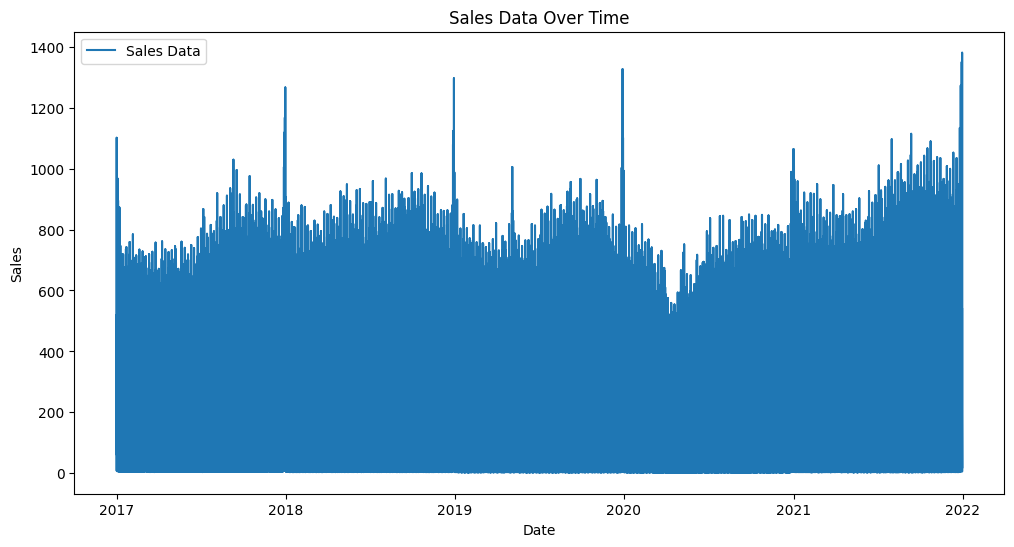

In [4]:
# Visualize data
plt.figure(figsize=(12, 6))
plt.plot(df["num_sold"], label="Sales Data")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Data Over Time")
plt.legend()
plt.show()

In [5]:
# Data preprocessing
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["num_sold"]])

In [6]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

In [7]:
#data_array = df["num_sold"].values
seq_length = 30  # Using past 30 days to predict next day
X, y = create_sequences(df_scaled, seq_length)

In [8]:
print(X[1])

[[0.04644412]
 [0.00507983]
 [0.0413643 ]
 [0.0341074 ]
 [0.06240929]
 [0.06966618]
 [0.00870827]
 [0.05878084]
 [0.04862119]
 [0.24528302]
 [0.26777939]
 [0.03701016]
 [0.26269956]
 [0.2053701 ]
 [0.14513788]
 [0.14296081]
 [0.02104499]
 [0.14513788]
 [0.09869376]
 [0.19738752]
 [0.20754717]
 [0.03265602]
 [0.19303338]
 [0.17924528]
 [0.75399129]
 [0.79753266]
 [0.11901306]
 [0.76923077]
 [0.62699565]
 [0.06531205]]


In [9]:
print(y[1])

[0.06313498]


In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

109536 109536 27384 27384


In [12]:
# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer='adam', loss='mse')

In [14]:
# Train model
history = model.fit(X_train, y_train, epochs=1, batch_size=16, validation_data=(X_test, y_test))

6846/6846 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - loss: 0.0087 - val_loss: 5.9898e-04


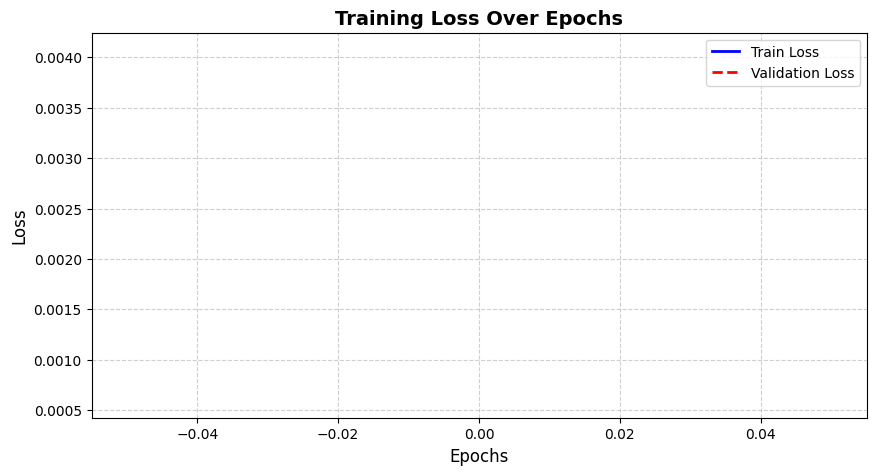

In [15]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2, linestyle='--')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [16]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

856/856 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


In [17]:
# Example prediction
example_idx = 100
example_date = df.index[len(df) - len(y_test) + example_idx]
print(f"Example Prediction Date: {example_date.strftime('%B %Y')}")
print(f"Actual Sales: {y_test_inv[example_idx][0]:.2f}")
print(f"Predicted Sales: {y_pred_inv[example_idx][0]:.2f}")

Example Prediction Date: January 2021
Actual Sales: 161.00
Predicted Sales: 90.83


In [18]:
# Example prediction
example_idx = 6
example_date = df.index[len(df) - len(y_test) + example_idx]
print(f"Example Prediction Date: {example_date.strftime('%B %Y')}")
print(f"Actual Sales: {y_test_inv[example_idx][0]:.2f}")
print(f"Predicted Sales: {y_pred_inv[example_idx][0]:.2f}")

Example Prediction Date: December 2020
Actual Sales: 83.00
Predicted Sales: 97.34


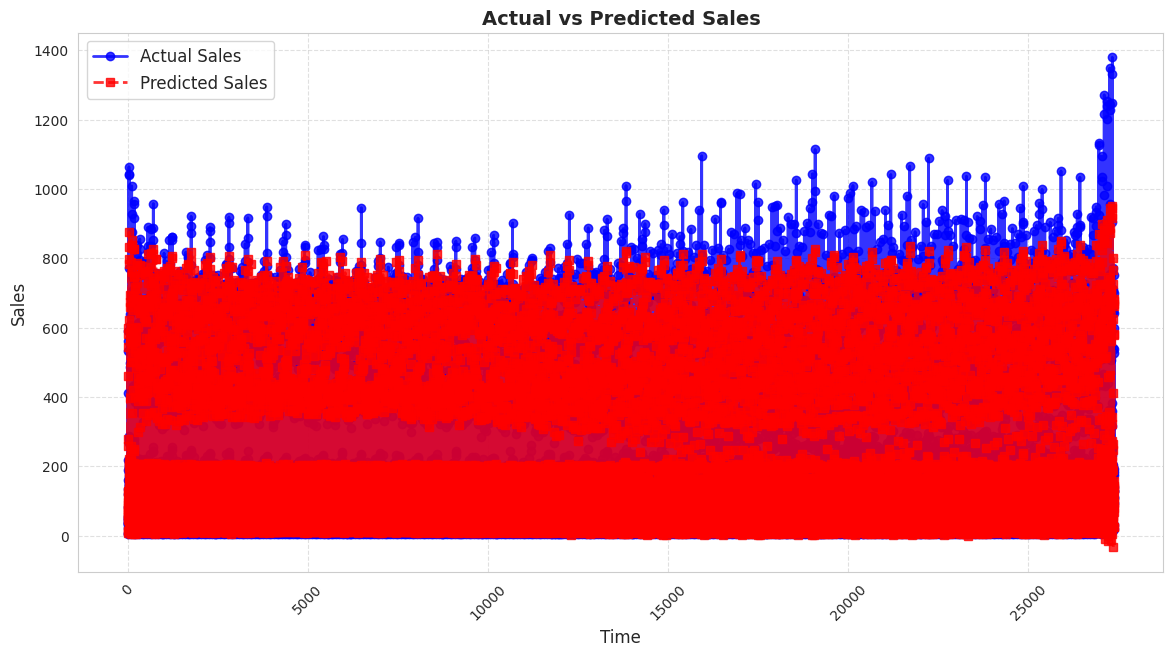

In [19]:
# Plot predictions
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
plt.plot(y_test_inv, label='Actual Sales', linestyle='-', marker='o', color='blue', alpha=0.8, linewidth=2)
plt.plot(y_pred_inv, label='Predicted Sales', linestyle='--', marker='s', color='red', alpha=0.8, linewidth=2)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.title('Actual vs Predicted Sales', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()